## Introduction:

> #### NoteBook with a detailed explanation of models for predicting ICR - Age related condition.

> #### In this Notebook you'll learn how deep learning models along with Light GBM and CatBoost help predict if a person has any of the three diseases. 

> #### Use of sampling techniques to deal with the bias issue and to get minimum log loss


## About the data set:
*  The data set contains 53 anonymous features with Class as the target column.
*  We are given the Greeks data set which has Supplemental metadata that refers to additional information or descriptive data that is associated with the training dataset.
*  Our goal is to train the model in such a way that with the given information it would be able to predict the probability of whether a patient is having no or any of the three age-related conditions.

## Contents of NoteBook

* Grouping numerical columns and categorical columns for further processing.
* Pipeline for preprocessing of train and test data set. Taking necessary steps to clean the data, performing imputations and handling the categorical values, and wrapping them up in a pipeline to avoid data leakage. 
* Dealing with outliers so that it wouldn't affect the model while finding the patterns during the training. 
* Practicing resampling and undersampling to deal with bias problems so that our model doesn't make biased predictions.
* Using class weights for mitigating class imbalance and ensuring fair representation.
* Used confusion matrix to adjust the probabilities to draw better results.
* Implementation of feature engineering to the columns such as applying log and square transformations to some features based on its histogram tail.
* Removing the features which don't contribute or contribute less to the predictions.


## Model Selection

* Tried to get the best results using deep learning models(Neural network), gradient boosting framework(Light GBM) and CatBoost
* Used modified Balanced log loss function to train the model and get the best weights for the features.

## References 
* [💡 Different strategies for Imbalanced target](http://www.kaggle.com/code/maryiaznak/different-strategies-for-imbalanced-target) by MARYIA ZNAK



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


> Importing necessary libraries needed in the notebook

In [2]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import tensorflow as tf
from sklearn.model_selection import KFold
from keras import Sequential
from tensorflow import keras
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing  import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold 
from sklearn.metrics import log_loss, make_scorer
from lightgbm import LGBMClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
train_data = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
test_data = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
greeks_data = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")

In [4]:
#  Grouping numeric and categorical features.
id_col = 'Id'

train_data = train_data.drop(columns = id_col)
sub = test_data.pop(id_col).to_frame()

target_col = 'Class'
cat_features = ['EJ']
num_features = [col for col in train_data.columns if col not in cat_features and col != target_col]

## Visualize the Numeric Columns 

> Here we are visualizing how numeric data is distributed. From this visualization we'll know what columns are skewed and what columns needs some transformation and such analysis.

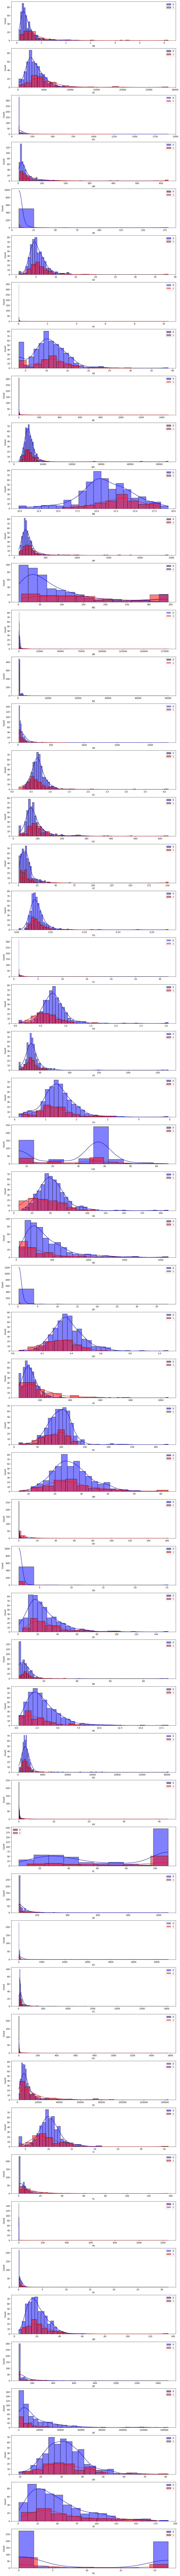

In [5]:
plt.figure(figsize=(14, 4 * len(num_features)))

for i, col in enumerate(num_features, start = 1):
    plt.subplot(len(num_features), 1, i)
    
    sns.histplot(train_data.loc[train_data[target_col] == 0, col], kde = True, color = 'blue', label = '0')
    sns.histplot(train_data.loc[train_data[target_col] == 1, col], kde = True, color = 'red', label = '1')
    plt.legend()

In [6]:
cols_to_drop = ['DV', 'EH']

train_data = train_data.drop(columns = cols_to_drop, axis=1)
test_data = test_data.drop(columns = cols_to_drop, axis=1)

num_features = [feat for feat in num_features if feat not in cols_to_drop]


> In the above cell we removed those two columns 'DV', 'EH' because they were not contributing to the predictions. And below we separated the columns which perform much better after being transformed into log and square. 

In [7]:
# log1p_cols = ['AX', 'BD ', 'BP', 'CC', 'CD ', 'CF', 'CR', 'CS', 'CU', 'DE', 'EE', 'EG', 'FC', 'FE', 'FI', 'GB', 'GF']
# sqrt_cols = ['DA', 'DH', 'DL', 'DN', 'GH', 'GI']

log1p_cols = ['AB','AH','AM','AR','AY','BC','BQ','BR','BZ','CB','CF','CL','CS','DE','DF','DI','DU','DY','EB','EE','EP','EU','FC','FE','FL','FS','GE','GF','GI']
sqrt_cols = ['AF','AX','BP','CD ','BD ','CC','CH','DA','DH','EG','FI','GB','GH']

y = train_data.pop(target_col)

> log1p_cols are the columns which are left-skewed and sqrt_cols are the columns are the columns which are right skewed  we are peforming transforms on these to fix the skewness.
> 
> By performing these transformations, you can modify the data distribution and achieve better alignment with statistical assumptions or modeling techniques that assume certain data characteristics. Ultimately, the choice of transformation depends on the specific characteristics of the data, the objectives of the analysis, and the requirements of the modeling or statistical methods being used.

In [8]:
# Here we are doing the train-val split because we don't want any data leakage happening while checking how the model does on validation set.

X_train, X_val, y_train, y_val = train_test_split(train_data, y, test_size=0.1, random_state=42)
X_train.isna().sum() # Check if there are any NaN values in the dataset.

AB      0
AF      0
AH      0
AM      0
AR      0
AX      0
AY      0
AZ      0
BC      0
BD      0
BN      0
BP      0
BQ     56
BR      0
BZ      0
CB      2
CC      3
CD      0
CF      0
CH      0
CL      0
CR      0
CS      0
CU      0
CW      0
DA      0
DE      0
DF      0
DH      0
DI      0
DL      0
DN      0
DU      1
DY      0
EB      0
EE      0
EG      0
EJ      0
EL     55
EP      0
EU      0
FC      1
FD      0
FE      0
FI      0
FL      1
FR      0
FS      2
GB      0
GE      0
GF      0
GH      0
GI      0
GL      1
dtype: int64

### Pipeline for preprocessing 

> Defining a pipeline (log_pipeline) for specific columns that involve applying the imputing missing values using KNN imputer, log1p function and standard scaling.
> 
> Defining another pipeline (sqrt_pipeline) for specific columns that involve applying the imputing missing values using KNN imputer, sqrt function and standard scaling.
> 
> And another pipeline for the rest of the features. Combining all the transformers into a ColumnTransformer (preprocessor) that applies each transformer to the specified columns.

In [9]:
log_pipeline =   Pipeline(steps=[ 
    ('imputer_1', KNNImputer(n_neighbors = 5)),
    ("log1p", (FunctionTransformer(np.log1p, validate=False))),
    ('scaler_1', StandardScaler())
   
 ])

sqrt_pipeline =   Pipeline(steps=[ 
    ('imputer_1', KNNImputer(n_neighbors = 5)),
    ("sqrt", (FunctionTransformer(np.sqrt, validate=False))),
    ('scaler_1', StandardScaler())
    
 ])

other_num_pipeline = Pipeline(steps=[ 
     ('imputer_1', KNNImputer(n_neighbors = 5)),
     ('scaler_1', StandardScaler())   

])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', drop = 'first', sparse_output = False))
])
transformed_cols = log1p_cols + sqrt_cols
other_nums = [x for x in num_features if x not in transformed_cols]
preprocessor = ColumnTransformer(
    transformers=[
         ("log1p", log_pipeline ,log1p_cols),
        ("sqrt", sqrt_pipeline ,sqrt_cols),
        ("num", other_num_pipeline ,other_nums),# Impute missing values and scale numerical features
        ("cat", categorical_transformer ,cat_features)  # One-hot encode categorical features  
    ])


> By calling the fit method on the preprocessor object with X_train as the argument, the transformer pipelines defined in the ColumnTransformer are fitted to the corresponding subsets of the training data.

In [10]:
X_train_preprocessed = preprocessor.fit(X_train)


> If you have a separate training and testing/validation dataset, it's generally recommended to use fit on the training data and then transform on both the training and testing/validation data separately. This ensures that the transformations are based only on the training data to avoid any data leakage

In [11]:
X_train_preprocessed = preprocessor.transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(test_data)


> What we are doing below is for the transformed training datasets i.e. X_train_preprocessed,  we are finding the outliers and removing the outliers from training set.

In [12]:
X_train_preprocessed.shape

from sklearn.ensemble import IsolationForest

outliers_pred = IsolationForest(random_state = 42).fit_predict(X_train_preprocessed)
n = np.sum(outliers_pred == -1)
print('No of outliers: ', n)


No of outliers:  14


> The purpose of using the IsolationForest algorithm in this context is to identify outliers or anomalies in the preprocessed training dataset. These outliers could be instances that deviate significantly from the majority of the data points or exhibit unusual patterns. The count of outliers (n) provides an estimate of the number of potentially anomalous samples in the dataset.

In [13]:
final_train_matrix = X_train_preprocessed[outliers_pred == 1, ...]
y = y_train.iloc[outliers_pred == 1]

y = pd.DataFrame(y, columns=['Class'])
y = y.reset_index(drop=True)

> The resulting final_train_matrix contains the preprocessed training data with outliers removed, and y contains the corresponding target variable filtered to align with the inlier samples. These filtered datasets can be used for subsequent modeling or analysis, focusing on the instances that are considered inliers by the Isolation Forest algorithm.
> 
> It's important to note that the decision to remove outliers depends on the specific characteristics of the dataset and the goals of the analysis. Careful consideration should be given to the potential impact of outlier removal on the overall dataset and the specific modeling task.

In [14]:
num_features.append('EJ') #adding EJ in num_features column after one hot encoding
condensed_data = pd.DataFrame(final_train_matrix, columns = num_features)
condensed_data.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DY', 'EB', 'EE',
       'EG', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB',
       'GE', 'GF', 'GH', 'GI', 'GL', 'EJ'],
      dtype='object')

In [15]:
condensed_data_1 = pd.concat([condensed_data, y], axis=1)

> We need to check thoroughly  if our dataset contains NaN values or not and make sure to deal with them before any further processing. Dealing with missing or NaN values is essential to ensure data integrity, maintain data quality, and enable accurate and reliable analyses and modeling processes.

In [16]:
X_val_preprocessed = pd.DataFrame(X_val_preprocessed , columns = num_features)
y_val = pd.DataFrame(y_val)
y_val = y_val.reset_index(drop = True)
condensed_val_data = pd.concat([X_val_preprocessed, y_val], axis=1)
condensed_val_data

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ,Class
0,0.149160,1.626574,-0.655252,-0.352698,-0.375492,1.179940,0.114379,-0.160393,-0.449734,-1.041060,...,0.206832,1.087469,-0.133050,0.342519,-1.536652,-0.044792,-0.035690,-0.824433,1.0,1
1,1.764336,4.299015,1.328673,-0.352698,1.248503,1.700460,1.174019,-0.292297,2.279185,2.086333,...,-1.115621,1.298290,-0.164539,1.254568,-0.174935,-0.070038,-0.032469,-0.821786,1.0,0
2,-0.419420,-0.500387,-0.549298,-0.151121,-0.243247,-0.692849,-0.154061,-0.614352,-0.449734,0.119960,...,0.629213,-1.354360,-0.118913,0.369344,-1.181252,-0.103817,-0.061452,1.301366,0.0,0
3,1.426788,-0.092701,0.253377,-0.352698,-0.375492,1.087266,-0.076714,1.286319,1.103823,-0.951323,...,0.407966,0.813288,-0.031701,1.063440,0.804190,-0.064902,-0.051109,-0.816544,1.0,1
4,2.209314,1.677855,1.966933,1.140235,-0.375492,2.625637,0.641717,0.837397,-0.449734,-1.346357,...,-0.426738,0.678687,0.839823,1.128826,-0.450128,-0.079963,-0.057380,-0.826597,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,-0.724162,-0.500387,-0.252344,-0.352698,1.451086,-0.692849,0.178614,0.029058,-0.449734,0.541791,...,0.744865,-1.354360,0.318943,-0.471451,1.108681,-0.103817,-0.027778,1.301366,0.0,0
58,1.935686,0.846859,1.966843,-0.352698,-0.375492,-0.692849,-0.911571,1.553794,-0.449734,0.783556,...,-0.014415,0.777393,0.674823,-0.583781,-1.293866,-0.096939,-0.009034,-0.598944,1.0,0
59,-0.197937,-0.500387,-0.790364,-0.352698,-0.375492,-0.692849,-0.513032,-0.052365,-0.449734,-0.289477,...,-1.492746,0.877998,0.495462,-0.044766,-0.794012,-0.087537,-0.037100,-0.827070,1.0,0
60,-1.050392,-0.500387,-2.136596,-0.352698,0.737015,0.413917,-2.843382,-0.619082,-0.449734,-0.651804,...,0.076096,-1.354360,0.982459,-0.191466,1.108681,-0.103817,-0.034027,1.301366,0.0,0


In [17]:
condensed_val_data.isna().sum()

AB       0
AF       0
AH       0
AM       0
AR       0
AX       0
AY       0
AZ       0
BC       0
BD       0
BN       0
BP       0
BQ       0
BR       0
BZ       0
CB       0
CC       0
CD       0
CF       0
CH       0
CL       0
CR       0
CS       0
CU       0
CW       0
DA       0
DE       0
DF       0
DH       0
DI       0
DL       0
DN       0
DU       0
DY       0
EB       0
EE       0
EG       0
EL       0
EP       0
EU       0
FC       0
FD       0
FE       0
FI       0
FL       0
FR       0
FS       0
GB       0
GE       0
GF       0
GH       0
GI       0
GL       0
EJ       0
Class    0
dtype: int64

In [18]:
X_test_1 = pd.DataFrame(X_test_preprocessed, columns = num_features)
X_test_1

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,EJ
0,-1.660951,-12.070511,-3.864565,-7.639153,-0.939632,-1.722548,-3.978914,-6.722721,-8.661671,-4.436227,...,-2.806921,-2.518527,-1.83192,-3.319887,-3.234424,-1.835386,-0.108169,-0.070857,-0.829284,0.0
1,-1.660951,-12.070511,-3.864565,-7.639153,-0.939632,-1.722548,-3.978914,-6.722721,-8.661671,-4.436227,...,-2.806921,-2.518527,-1.83192,-3.319887,-3.234424,-1.835386,-0.108169,-0.070857,-0.829284,0.0
2,-1.660951,-12.070511,-3.864565,-7.639153,-0.939632,-1.722548,-3.978914,-6.722721,-8.661671,-4.436227,...,-2.806921,-2.518527,-1.83192,-3.319887,-3.234424,-1.835386,-0.108169,-0.070857,-0.829284,0.0
3,-1.660951,-12.070511,-3.864565,-7.639153,-0.939632,-1.722548,-3.978914,-6.722721,-8.661671,-4.436227,...,-2.806921,-2.518527,-1.83192,-3.319887,-3.234424,-1.835386,-0.108169,-0.070857,-0.829284,0.0
4,-1.660951,-12.070511,-3.864565,-7.639153,-0.939632,-1.722548,-3.978914,-6.722721,-8.661671,-4.436227,...,-2.806921,-2.518527,-1.83192,-3.319887,-3.234424,-1.835386,-0.108169,-0.070857,-0.829284,0.0


In [19]:
X= condensed_data_1.drop('Class', axis = 1)
y = condensed_data_1['Class']

> This implementation of balanced log loss is designed to penalize your prediction compared to the actual. If actual is 0 and predicted is 1, the BLL takes log(0) which is near infinity but according to the evaluation method, we should be taking e15/e-15.
> So, basically this method guides us to give perfect prediction only if we are pretty sure otherwise penality would be very high.

In [20]:
# used the following notebook as a reference for balanced_logloss():
# https://www.kaggle.com/code/tetsutani/icr-iarc-eda-ensemble-and-stacking-baseline
def balanced_logloss(y_true, y_pred):
    # y_true - Series
    # y_pred - 2D array
    
    if len(y_pred.shape) == 1 or (len(y_pred.shape) == 2 
                                  and y_pred.shape[-1] == 1):
        y_pred = np.hstack((1 - y_pred.reshape(-1, 1), y_pred.reshape(-1, 1)))
    
    # this line is here to avoid np.log(0) situation
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true)
    
    assert nc.shape[0] == y_pred.shape[-1]
    
    class_count = nc.shape[0]
    W = [1/(nc[i]/y_true.shape[0]) for i in range(class_count)]
    logloss = sum([-W[i]/nc[i]*(np.sum(np.where(y_true == i, 1, 0) * np.log(y_pred[:, i]))) for i in range(class_count)]) / sum(W)
    
    return logloss

from sklearn.metrics import make_scorer

balanced_logloss_score_1 = make_scorer(balanced_logloss, 
                                     greater_is_better = False, 
                                     needs_proba = True)

# Undersampling using Random sampler

> As we are given a dataset which has a sampling problem (unbalanced data distribution) we are using undersampling technique to handel class imbalance and to deal with the trade-offs between computational efficiency, model performance, and the requirements of the specific application.

In [21]:

ru = RandomUnderSampler(sampling_strategy = 'majority',
                        random_state = 42,
                        replacement = True)


X_resampled, y_resampled = ru.fit_resample(X, y)

In [22]:
undersample_input = pd.DataFrame(np.hstack([X_resampled, y_resampled.to_frame()]), columns = condensed_data_1.columns)

# Tensor Flow Neural Network (with undersampled data)

> Below is the modified balanced log loss code we are defining so that the model can make improvements with respect to this defination.  

In [23]:
def balanced_logloss_tf(y_true, y_pred):
      # y_true: correct labels 0, 1
        # y_pred: predicted probabilities of class=1
        # Implements the Evaluation equation with w_0 = w_1 = 1.
        # Calculate the number of observations for each class
    zero = tf.constant(1e-15)
    N_0 = tf.clip_by_value(tf.math.reduce_sum(1 - y_true), zero,1e10)
    N_1 = tf.clip_by_value(tf.math.reduce_sum(y_true), zero,1e10)
    # Calculate the predicted probabilities for each class
    p_1 = tf.clip_by_value(y_pred, zero, 1-zero)
    p_0 = tf.clip_by_value(1-p_1, zero, 1-zero)
    # Calculate the average log loss for each class
    log_loss_0 = -tf.math.reduce_sum((1 - y_true) * tf.math.log(p_0)) / N_0 
    log_loss_1 = -tf.math.reduce_sum(y_true * tf.math.log(p_1)) / N_1 
    # return the (not further weighted) average of the averages
    return (log_loss_0 + log_loss_1)/2 

##### Fold 1
<class 'pandas.core.frame.DataFrame'>  -----  (114, 55)
2/2 [==============================] - 0s 5ms/step
(58, 1)
2/2 [==============================] - 0s 7ms/step - loss: 0.4376 - binary_accuracy: 0.8448
Balanced Log Loss :0.45283160467856914
 Model loss on the validation set: 0.4376269280910492
 Model accuracy on the validation set: 0.8448275923728943
Best Validation Loss: 0.5857
Best Validation Accuracy: 0.8621
2/2 [==============================] - 0s 7ms/step - loss: 0.4376 - binary_accuracy: 0.8448
------------------------------------------------------
##### Fold 2
<class 'pandas.core.frame.DataFrame'>  -----  (115, 55)
2/2 [==============================] - 0s 6ms/step
(57, 1)
2/2 [==============================] - 0s 7ms/step - loss: 0.4611 - binary_accuracy: 0.7544
Balanced Log Loss :0.8795028684139072
 Model loss on the validation set: 0.4611048102378845
 Model accuracy on the validation set: 0.7543859481811523
Best Validation Loss: 0.6301
Best Validation Accur

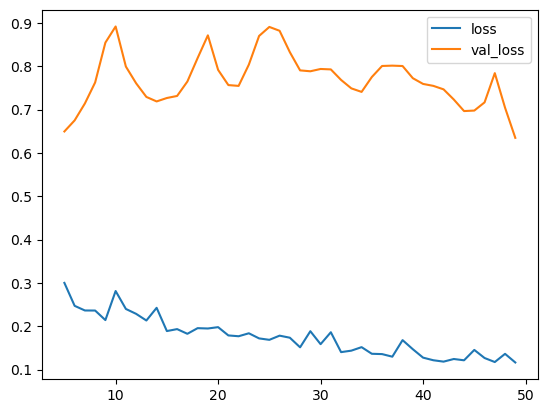

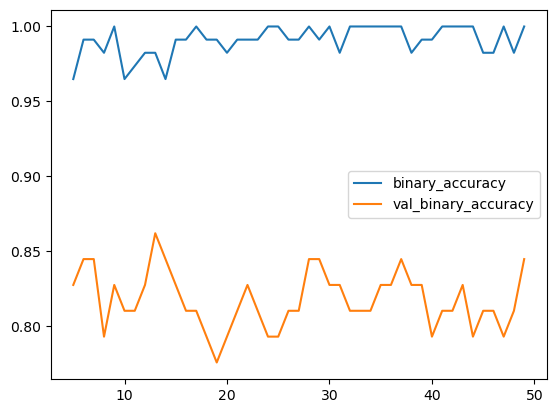

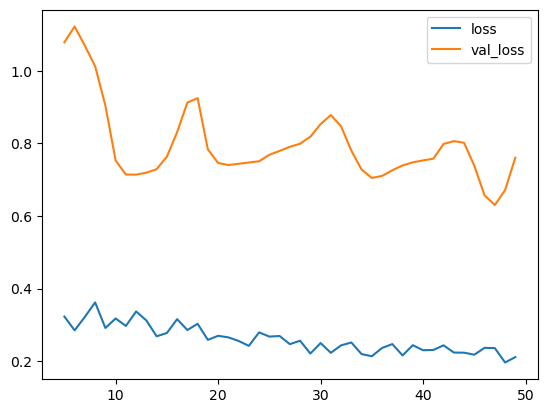

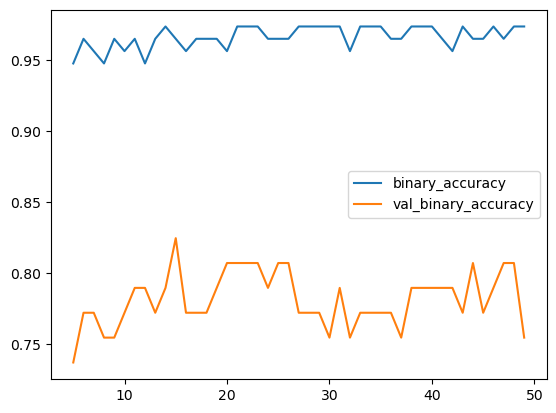

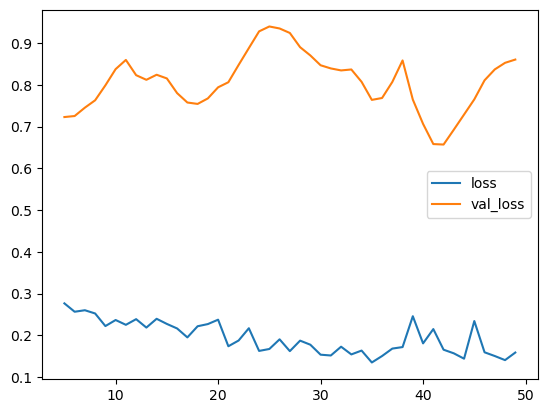

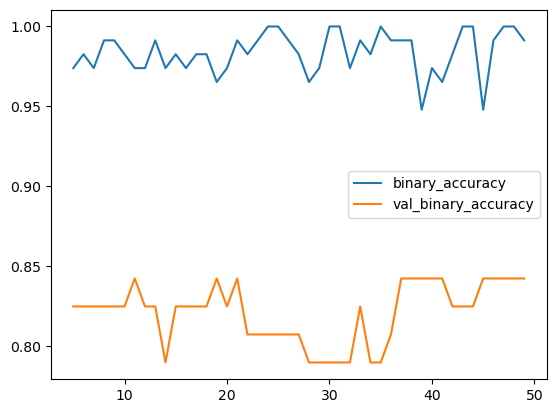

In [24]:

neural_models = {}
fold_losses = {}
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True)

early_stopping = EarlyStopping(
    min_delta=0.08, # minimium amount of change to count as an improvement
    patience=60,
    # how many epochs to wait before stopping
    restore_best_weights=True,
)

for i, (train_index, valid_index) in enumerate(stratified_kfold.split(X=undersample_input, y = undersample_input['Class'])):
    
    print('##### Fold',i+1)
    # Split the data into training and validation sets
    train_df_1 = undersample_input.iloc[train_index]
    valid_df_1 = undersample_input.iloc[valid_index]
    valid_ids_1 = valid_df_1.index.values
    
    print(type(train_df_1), " ----- ", train_df_1.shape)
    X_train_neural = train_df_1.iloc[:,:-1]
    y_train_neural = train_df_1['Class']
    X_val_neural = valid_df_1.iloc[:,:-1]
    y_val_neural = valid_df_1['Class']
    input_shape = [X_train_neural.shape[1]]
    

    tf.random.set_seed(432)
    # Compile and train the neural network
    neural_model = tf.keras.Sequential([
                                tf.keras.layers.Dense(64,input_shape=input_shape, activation = 'relu'), #we may right it "tf.keras.activations.relu" too
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.Dense(200, activation = 'sigmoid',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                tf.keras.layers.Dropout(0.6),
                                tf.keras.layers.Dense(150, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                tf.keras.layers.Dense(75, activation = 'sigmoid',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Dense(120, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)), #we may right it "tf.keras.activations.relu" too
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(80, activation = 'sigmoid',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                tf.keras.layers.Dense(32, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                tf.keras.layers.Dropout(0.4),
                                tf.keras.layers.BatchNormalization(),
                                tf.keras.layers.Dense(1, activation = 'sigmoid')])
    
    neural_model.compile( loss= balanced_logloss_tf,optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005, amsgrad = True ,use_ema = False),metrics = ['binary_accuracy'])
    
    neural_model.fit(X_train_neural, y_train_neural.astype("float64"), batch_size=80, epochs = 50 ,callbacks=[early_stopping], verbose = 0)
    neural_models[f"fold_{i+1}"] =  neural_model
    
    y_val_neural_pred = neural_model.predict(X_val_neural)

    history = neural_model.fit(
    X_train_neural, y_train_neural.astype("float64"),
    validation_data=(X_val_neural, y_val_neural.astype("float64")),
    batch_size=80,
    epochs=  50,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0  # turn off training log 
    )
    
    print(y_val_neural_pred.shape)
    y_val_pred = np.hstack((1 - y_val_neural_pred.reshape(-1, 1), y_val_neural_pred.reshape(-1, 1)))
    
    loss, accuracy = neural_model.evaluate(X_val_neural, y_val_neural.astype("float64"))
    print(f'Balanced Log Loss :{balanced_logloss(y_val_neural.astype("float64"),y_val_pred )}')
    print(f' Model loss on the validation set: {loss}')
    print(f' Model accuracy on the validation set: {accuracy}')
    
    history_df = pd.DataFrame(history.history)
    history_df.loc[5:, ['loss', 'val_loss']].plot()
    history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

    print(("Best Validation Loss: {:0.4f}" +\
          "\nBest Validation Accuracy: {:0.4f}")\
          .format(history_df['val_loss'].min(), 
                  history_df['val_binary_accuracy'].max()))

    fold_losses[f"fold_{i+1}"] = neural_model.evaluate(X_val_neural, y_val_neural.astype("float64"))
    


    
    print("------------------------------------------------------")

#### Validation check for neural model

> The train-val split we did earlier in the notebook is being used now. To know how our model isperforming on a completely new dataset.

In [25]:
X_v = condensed_val_data.drop('Class', axis = 1)
y_vv = condensed_val_data['Class']

In [26]:
y_vv_preds = neural_model.predict(X_v)

y_val_vv = np.hstack((1 - y_vv_preds.reshape(-1, 1), y_vv_preds.reshape(-1, 1)))

loss_nn_val, accuracy_nn_val = neural_model.evaluate(X_v, y_vv.astype("float64"))
print(f'Balanced Log Loss :{balanced_logloss(y_vv.astype("float64"),y_val_vv )}')
print(f' Model loss on the validation set: {loss_nn_val}')
print(f' Model accuracy on the validation set: {accuracy_nn_val}')


2/2 [==============================] - 0s 7ms/step - loss: 0.8000 - binary_accuracy: 0.8710
Balanced Log Loss :0.56439229888708
 Model loss on the validation set: 0.7999927401542664
 Model accuracy on the validation set: 0.8709677457809448


> We can see that the balanced log loss and the accuracy we got from the model on training set is completely different from what we got on the validation set. So we can get to some conclusion that how our model may work on the test data.

2/2 [==============================] - 0s 4ms/step


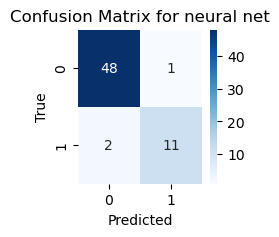

In [27]:
threshold = 0.68
all_predictions = []
for (n, model) in neural_models.items():
    predictions = model.predict(X_v)
    all_predictions.append(predictions)   
average_predictions = np.mean(all_predictions, axis=0)  
binary_predictions = np.where(average_predictions >= threshold, 1, 0)
confusion_mat = confusion_matrix(y_vv, binary_predictions)
plt.figure(figsize=(2, 2))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for neural net")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

> In the above cell we plotted a confusion matrix and also added a threshold parameter that convert the model's prediction probabilities into binary predictions. We adjust the threshold and see how it is helping to get more accurate predictions. After adjusting the threshold we were getting little better score in LB.
> 
> Note that you can change the value of threshold according to the matrix and see after changing if the predictions are getting any better.

**Generating predictions for the test dataset using an ensemble of neural network models (neural_models).**

In [28]:
th = 0.65
tmp = np.zeros(shape=(X_test_1.shape[0],1))

for (a, model_nn) in neural_models.items():
    p = model_nn.predict(X_test_1)
    tmp = np.add(p, tmp)
y_test_df = pd.DataFrame(tmp/len(neural_models), columns = ['class_1'])
y_test_df['class_1'] = y_test_df['class_1'].apply(lambda p : 0.95 if p >= th else p).apply(lambda p : 0.05 if p <= 1-th else p)
y_test_df['class_0']= 1- y_test_df['class_1']
y_test_df


1/1 [==============================] - 0s 25ms/step


,class_1,class_0
0,0.05,0.95
1,0.05,0.95
2,0.05,0.95
3,0.05,0.95
4,0.05,0.95


# LightGBM (with undersampled data)

> In the code below it performs hyperparameter tuning using grid search with cross-validation for a LightGBM classifier.

> It aims to find the best combination of hyperparameters (you can play around with different values, but for execution time purpose we put the best combination) for the LightGBM classifier by searching through the specified parameter grid. The chosen scoring metric, balanced_logloss_score_1, is used to evaluate the performance of each parameter combination.

In [29]:
param_grid = {
    'boosting_type': ['goss'],
    'learning_rate': [ 0.2],
    'n_estimators': [ 50],
    'max_depth': [3],
    'subsample': [0.4],
    'colsample_bytree': [  0.7],
    'class_weight': ['balanced'],
    'metric': ['none'],
    'is_unbalance': [True],
    'random_state': [42]
}


lgbm_clf = lgbm.LGBMClassifier(random_state = 42)
grid_search_lgbm_under_sampl_clf = GridSearchCV(lgbm_clf, 
                                    param_grid,
                                    cv = 7,
                                    scoring = balanced_logloss_score_1)

grid_search_lgbm_under_sampl_clf.fit(X_resampled, y_resampled)


GridSearchCV(cv=7, estimator=LGBMClassifier(random_state=42),
             param_grid={'boosting_type': ['goss'],
                         'class_weight': ['balanced'],
                         'colsample_bytree': [0.7], 'is_unbalance': [True],
                         'learning_rate': [0.2], 'max_depth': [3],
                         'metric': ['none'], 'n_estimators': [50],
                         'random_state': [42], 'subsample': [0.4]},
             scoring=make_scorer(balanced_logloss, greater_is_better=False, needs_proba=True))

In [30]:
def custom_f1_score(y_true, y_pred):
    y_pred = np.where(y_pred < 0.5, 0, 1)
    return f1_score(y_true, y_pred)


y_pred = grid_search_lgbm_under_sampl_clf.best_estimator_.predict(final_train_matrix)
y_pred_proba = grid_search_lgbm_under_sampl_clf.best_estimator_.predict_proba(final_train_matrix)

print(grid_search_lgbm_under_sampl_clf.best_params_)

print('balanced_logloss train: ', balanced_logloss(y, y_pred_proba))
print('f1_score train: ', custom_f1_score(y, y_pred))

{'boosting_type': 'goss', 'class_weight': 'balanced', 'colsample_bytree': 0.7, 'is_unbalance': True, 'learning_rate': 0.2, 'max_depth': 3, 'metric': 'none', 'n_estimators': 50, 'random_state': 42, 'subsample': 0.4}
balanced_logloss train:  0.21066671858454514
f1_score train:  0.7813953488372093


> The code above performs model evaluation by calculating the balanced log loss and F1 score on the training data using the best estimator found during grid search for the LightGBM model.

In [31]:

k = 3
kf = KFold(n_splits=k, shuffle=True)


lgbm_models = {}
log_losses = []
balanced_log_losses = []
param_grid_kf = {
    'boosting_type': ['gbdt'],
    'learning_rate': [ 0.2 ],
    'n_estimators': [ 50],
    'max_depth': [3],
    'subsample': [0.4],
    'colsample_bytree': [  0.7],
    'metric': ['none'],
    'is_unbalance': [True],
    'random_state': [437]
}

   
for i, (train_index, valid_index) in enumerate(kf.split(X=undersample_input)):
    
    print('##### Fold',i+1)
    # Split the data into training and validation sets
    train_df_1 = undersample_input.iloc[train_index]
    valid_df_1 = undersample_input.iloc[valid_index]
    valid_ids_1 = valid_df_1.index.values

    print(type(train_df_1), " ----- ", train_df_1.shape)
    X_train_gbm = train_df_1.iloc[:,:-1]
    y_train_gbm = train_df_1['Class']
    X_val_gbm = valid_df_1.iloc[:,:-1]
    y_val_gbm = valid_df_1['Class']
    
    gbm = lgbm.LGBMClassifier(reg_lambda=0.1, reg_alpha=0.1, random_state = 42)
    lgbm_model = GridSearchCV(gbm,
                            param_grid_kf,
                            cv = 7,
                            scoring = balanced_logloss_score_1)

    lgbm_model.fit(X_train_gbm, y_train_gbm)
    lgbm_models[f"fold_{i+1}"] =  lgbm_model
    y_pred = lgbm_model.predict_proba(X_val_gbm)

    logloss = log_loss(y_val_gbm, y_pred)
    balanced_logloss_1 = balanced_logloss(y_val_gbm, y_pred[:, 1])

    log_losses.append(logloss)
    balanced_log_losses.append(balanced_logloss)


    print(f"Fold: {i+1}, log loss on validation: {round(logloss, 3)}, balanced los loss on validation: {round(balanced_logloss_1, 3)}")
   
    print("================================================================================")

##### Fold 1
<class 'pandas.core.frame.DataFrame'>  -----  (114, 55)
Fold: 1, log loss on validation: 0.283, balanced los loss on validation: 0.283
##### Fold 2
<class 'pandas.core.frame.DataFrame'>  -----  (115, 55)
Fold: 2, log loss on validation: 0.413, balanced los loss on validation: 0.393
##### Fold 3
<class 'pandas.core.frame.DataFrame'>  -----  (115, 55)
Fold: 3, log loss on validation: 0.346, balanced los loss on validation: 0.313


#### Validation check for light GBM model

In [32]:
y_gb_preds = lgbm_model.predict_proba(X_v)

# y_val_vv = np.hstack((1 - y_vv_preds.reshape(-1, 1), y_vv_preds.reshape(-1, 1)))

logloss_val = log_loss(y_vv, y_gb_preds)
balanced_logloss_1_val = balanced_logloss(y_vv, y_gb_preds[:, 1])

print('log loss on validation: ', logloss_val) 
print('balanced log loss on validation: ', balanced_logloss_1_val) 

log loss on validation:  0.4085359886631334
balanced log loss on validation:  0.3198010737211602


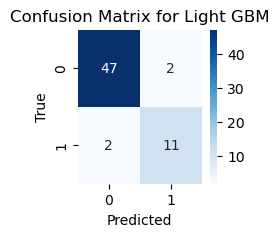

In [33]:
threshold = 0.7
all_predictions_gbm = []
for (g, model_gbm) in lgbm_models.items():
    predictions_gbm = model_gbm.predict(X_v)
    all_predictions_gbm.append(predictions_gbm)   
average_predictions_gbm = np.mean(all_predictions_gbm, axis=0)  
binary_predictions_gbm = np.where(average_predictions_gbm >= threshold, 1, 0)
confusion_mat_gbm = confusion_matrix(y_vv, binary_predictions_gbm)
plt.figure(figsize=(2, 2))
sns.heatmap(confusion_mat_gbm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Light GBM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**Generating predictions for the test dataset using an ensemble of Light GBM models (lgbm_models).**

In [34]:
tmp_gbm = np.zeros(shape=(X_test_1.shape[0], 1))

for j, model_g in lgbm_models.items():
    p_gbm = model_g.predict_proba(X_test_1)
    p_gbm = p_gbm[:, 1].reshape(-1, 1)  # Reshape the predictions to have shape (n_samples, 1)
    tmp_gbm = np.add(p_gbm, tmp_gbm)
    
average_prediction = tmp_gbm / len(lgbm_models)
y_test_gbm = pd.DataFrame(average_prediction, columns=['class_1'])
y_test_gbm['class_0']= y_test_gbm['class_1'].apply(lambda class1 :  1- class1)
y_test_gbm['class_1'] = y_test_gbm['class_1']
y_test_gbm

,class_1,class_0
0,0.141764,0.858236
1,0.141764,0.858236
2,0.141764,0.858236
3,0.141764,0.858236
4,0.141764,0.858236


# Catboost (using class weights)


> Earlier we used undersampled data to train neural net and Light GBM. But here we are training the model with class weights just to have some variation of dealing with the problem statement. 

# Class Weights

In [35]:
neg, pos = np.bincount(y_train)

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.60
Weight for class 1: 2.92


In [36]:


kfold = KFold(n_splits=3, shuffle=True, random_state=42)

log_losses_cat = []
balanced_log_losses_cat = []
scores = []
cat_models = {}


for i, (train_index, valid_index) in enumerate(kf.split(X=condensed_data_1)):
    
    print('##### Fold',i+1)
    # Split the data into training and validation sets
    train_df_2 = condensed_data_1.iloc[train_index]
    valid_df_2 = condensed_data_1.iloc[valid_index]
    valid_ids_2 = valid_df_2.index.values
    
    print(type(train_df_1), " ----- ", train_df_1.shape)
    X_train_cat = train_df_2.iloc[:,:-1]
    y_train_cat = train_df_2['Class']
    X_val_cat = valid_df_2.iloc[:,:-1]
    y_val_cat = valid_df_2['Class']
    
    
    # Create a CatBoost classifier
    cat_model = CatBoostClassifier(iterations=100, learning_rate=0.1, random_state=42,l2_leaf_reg=1.0,rsm=0.8,bagging_temperature=0.8, class_weights=class_weight)
    
    # Fit the model
    cat_model.fit(X_train_cat, y_train_cat)
    cat_models[f"fold_{i+1}"] =  cat_model
    # Make predictions on the test set
    y_pred_proba = cat_model.predict_proba(X_val_cat)[:, 1]
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_val_cat, y_pred_proba)
    scores.append(roc_auc)
    
    logloss_cat = log_loss(y_val_cat, y_pred_proba)
    balanced_logloss_cat = balanced_logloss(y_val_cat, y_pred_proba)
    
    log_losses.append(logloss_cat)
    balanced_log_losses.append(balanced_logloss_cat)
    
    roc_auc = roc_auc_score(y_val_cat, y_pred_proba)
    scores.append(roc_auc)
    print('Catboost Accuracy:', roc_auc)
    print(f"Fold: {i+1}, log loss on validation: {round(logloss_cat, 3)}, balanced los loss on validation: {round(balanced_logloss_cat, 3)}")
   
    print("================================================================================")


##### Fold 1
<class 'pandas.core.frame.DataFrame'>  -----  (115, 55)
0:	learn: 0.6048042	total: 69.2ms	remaining: 6.85s
1:	learn: 0.5142044	total: 78.4ms	remaining: 3.84s
2:	learn: 0.4574735	total: 87.4ms	remaining: 2.82s
3:	learn: 0.4064015	total: 95.5ms	remaining: 2.29s
4:	learn: 0.3558604	total: 107ms	remaining: 2.02s
5:	learn: 0.3296415	total: 114ms	remaining: 1.79s
6:	learn: 0.2884782	total: 121ms	remaining: 1.61s
7:	learn: 0.2613208	total: 129ms	remaining: 1.48s
8:	learn: 0.2341262	total: 137ms	remaining: 1.39s
9:	learn: 0.2086696	total: 145ms	remaining: 1.3s
10:	learn: 0.1984021	total: 155ms	remaining: 1.26s
11:	learn: 0.1812374	total: 165ms	remaining: 1.21s
12:	learn: 0.1643593	total: 171ms	remaining: 1.15s
13:	learn: 0.1525136	total: 178ms	remaining: 1.09s
14:	learn: 0.1422589	total: 184ms	remaining: 1.04s
15:	learn: 0.1333031	total: 191ms	remaining: 1s
16:	learn: 0.1221903	total: 197ms	remaining: 963ms
17:	learn: 0.1106259	total: 204ms	remaining: 930ms
18:	learn: 0.1041311	to

#### Validation check for Catboost

In [37]:
y_cb_preds = cat_model.predict_proba(X_v)

logloss_val_cat = log_loss(y_vv, y_cb_preds)
balanced_logloss_1_cat = balanced_logloss(y_vv, y_cb_preds[:, 1])

print('log loss on validation: ', logloss_val_cat) 
print('balanced log loss on validation: ', balanced_logloss_1_cat) 

log loss on validation:  0.153521215559402
balanced log loss on validation:  0.341816089573962


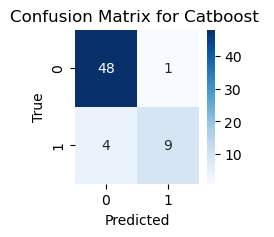

In [38]:
threshold = 0.98
all_predictions_c = []
for (g, model_c) in cat_models.items():
    predictions_c = model_c.predict(X_v)
    all_predictions_c.append(predictions_c)   
average_predictions_c = np.mean(all_predictions_c, axis=0)  
binary_predictions_c = np.where(average_predictions_c >= threshold, 1, 0)
confusion_mat_c = confusion_matrix(y_vv, binary_predictions_c)
plt.figure(figsize=(2, 2))
sns.heatmap(confusion_mat_c, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Catboost ")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**Generating predictions for the test dataset using an ensemble of CatBoost models (cat_models).**

In [39]:
tmp_cb = np.zeros(shape=(X_test_1.shape[0], 1))

for k, model_c in cat_models.items():
    p_cat = model_c.predict_proba(X_test_1)
    p_cat = p_cat[:, 1].reshape(-1, 1)  # Reshape the predictions to have shape (n_samples, 1)
    tmp_cb = np.add(p_cat, tmp_cb)
    
average_prediction_cat = tmp_cb / len(cat_models)
y_test_cat = pd.DataFrame(average_prediction_cat, columns=['class_1'])
y_test_cat['class_0']= y_test_cat['class_1'].apply(lambda class1 :  1- class1)
y_test_cat['class_1'] = y_test_cat['class_1']
y_test_cat

,class_1,class_0
0,0.096328,0.903672
1,0.096328,0.903672
2,0.096328,0.903672
3,0.096328,0.903672
4,0.096328,0.903672


In [40]:
average_probs = (y_test_gbm[['class_0', 'class_1']] + y_test_cat[['class_0', 'class_1']] +y_test_df[['class_0', 'class_1']])/ 3
# average_probs = (y_test_gbm[['class_0', 'class_1']] + y_test_cat[['class_0', 'class_1']])/ 2

average_probs

,class_0,class_1
0,0.903969,0.096031
1,0.903969,0.096031
2,0.903969,0.096031
3,0.903969,0.096031
4,0.903969,0.096031


> We took the average of all models for the prediction of test data and then gave it for the submission.

### Submitting to Kaggle

In [41]:
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
sample_submission['class_0'] = average_probs['class_0']
sample_submission['class_1'] = average_probs['class_1']
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission.head()

,Id,class_0,class_1
0,00eed32682bb,0.903969,0.096031
1,010ebe33f668,0.903969,0.096031
2,02fa521e1838,0.903969,0.096031
3,040e15f562a2,0.903969,0.096031
4,046e85c7cc7f,0.903969,0.096031
